# Use Geometric Center for Clustering

In [121]:
import numpy as np

rsd_ctr = np.genfromtxt('rsd_array_GeometricCentroids.csv', delimiter=',')
assert len(rsd_ctr) == 2454

## Decide an Appropriate K-Value

In [122]:
# To see what's a reasonable K-value
# SSE (Sum of Squared Errors) value vs. K value
# A proper k value locates a the turning point of the graph

from sklearn.cluster import KMeans
distortions = []
for i in range(1,20):
    km = KMeans(n_clusters=i,init="k-means++",n_init=10,
                max_iter=3000,tol=1e-7,random_state=None)
    # n_init-初始样本中心个数；max_iter:设置最大迭代次数；tol:设置算法的容错范围SSE(簇内误平方差);init:random表示使用Kmeans算法，默认是k-means++

    km.fit(rsd_ctr)
    # get Sum of Squared Errors
    distortions.append(km.inertia_)

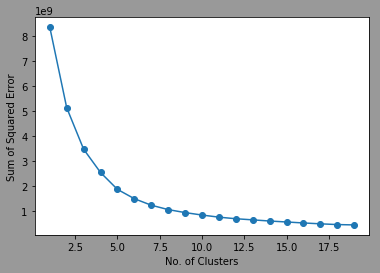

In [123]:
# show
import matplotlib.pyplot as plt
plt.figure(facecolor='.6')
plt.plot(range(1,20),distortions,marker="o")
plt.xlabel("No. of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

### Acordingly, 10 would be a fair k-value.

# Run K-Means & Draw the Graph

In [124]:
km = KMeans(n_clusters=10, random_state=None)
rsd_ctr_clustered = km.fit_predict(rsd_ctr)
# each item in rsd_clustered is the group number of one coordinate in rsd

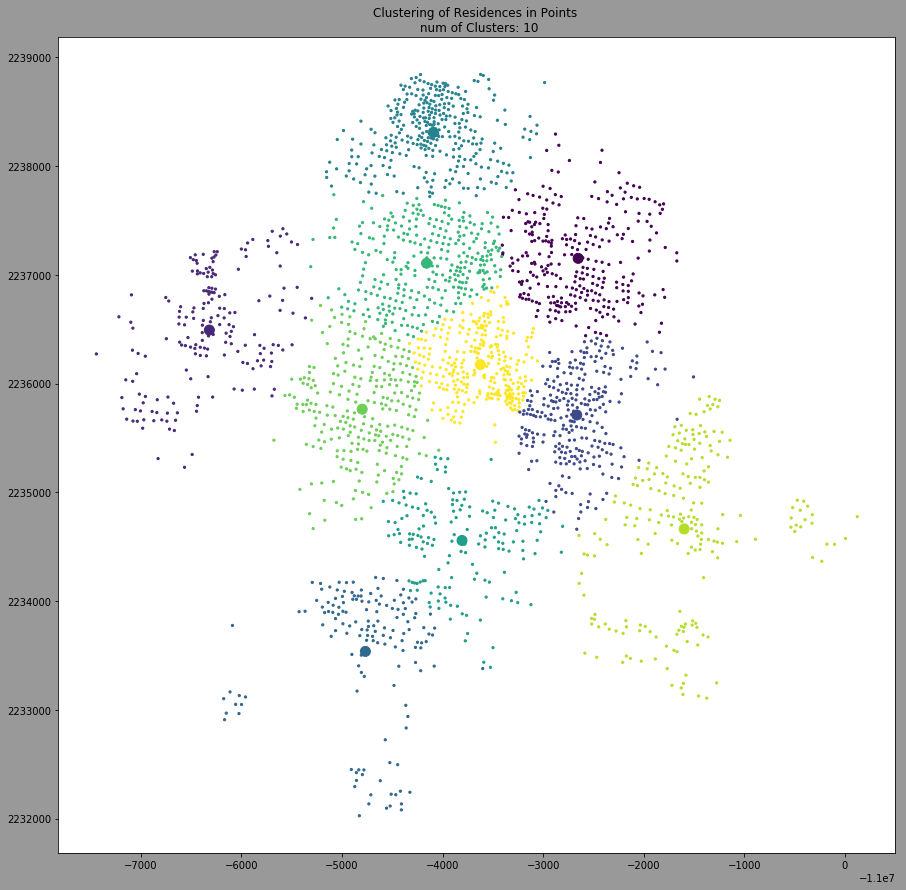

In [125]:
plt.figure(figsize=(15,15), facecolor='0.6')

plt.scatter(rsd_ctr[:, 0], rsd_ctr[:, 1], c = rsd_ctr_clustered, s = 5)  # c = sequence of color
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c = [i for i in range(10)], s = 100)

plt.title("Clustering of Residences in Points \n num of Clusters: 10")
plt.show()

# Analyzing Clusters - Area

For each cluster, produce its total area, built area, and number of structures, and other relevant info

In [126]:
import numpy as np
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape, LineString
import pandas as pd

num_clusters = len(km.cluster_centers_)

In [127]:
rawMap = fiona.open('Data/Residences.shp')

# assort all the geoPy objects in the geoMap list
geoMap = []
for i in range(len(rawMap)):
    if rawMap[i]['geometry'] == None:
        print(i, 'is None')
    else:
        try:
            geoMap.append(Polygon(shape(rawMap[i]['geometry'])))
        except:
            print(i, 'has error')
assert len(geoMap) == len(rsd_ctr)

2447 has error
2448 is None


In [128]:
# assort all the geoPy objects in the geoMap list
geoMap = []
for i in range(len(rawMap)):
    if rawMap[i]['geometry'] == None:
        print(i, 'is None')
    else:
        try:
            geoMap.append(Polygon(shape(rawMap[i]['geometry'])))
        except:
            print(i, 'has error')
assert len(geoMap) == len(rsd_ctr)

2447 has error
2448 is None


In [129]:
# dfArea is a DataFrame that contain the area of each building center point
dfArea = pd.DataFrame( columns = ['area', 'cluster'])
dfArea.area = [m.area for m in geoMap]
labels = km.labels_
dfArea.cluster = labels

In [130]:
# Setup the result DataFrame
Results = pd.DataFrame(columns = 
['number_of_buildings', 'total_area', 'built_area', 'building_density',
 'max_area', 'min_area', 'mean_area', 'Gini_coefficient' ])

#### Calculate number_of_buildings, built_area, max_area, min_area, mean_area

In [131]:
# add data for cluster_number, number_of_buildings, total_area
Results.number_of_buildings = [len(dfArea[dfArea.cluster == i]) for i in range(num_clusters) ]
Results.built_area = [ sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.max_area = [ max(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.min_area = [ min(dfArea[dfArea.cluster == i].area) for i in range(num_clusters) ]
Results.mean_area = [ Results.total_area[i]/Results.number_of_buildings[i] for i in range(num_clusters) ]

#### Calculate Gini_coefficient

In [132]:
# Calculate Gini Coefficient for each cluster
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

Results.Gini_coefficient = [ gini(np.asarray(dfArea[dfArea.cluster == i].area)) for i in range(num_clusters) ]


#### Calculate total area of a cluster

In [133]:
# Calculate total area of each cluster region
# use the area convexHull of all center in the cluster
# http://scipy.github.io/devdocs/generated/scipy.spatial.ConvexHull.html
grouped_ctr = [[] for i in range(num_clusters)]
for i in range(len(rsd_ctr)):
    grouped_ctr[labels[i]].append(rsd_ctr[i])

In [134]:
# each item in convexhulls is a ConvexHull object consisted of the cluster
from scipy.spatial import ConvexHull

convexhulls = []
for i in range(num_clusters):
    convexhulls.append(ConvexHull(grouped_ctr[i]) )

Results.total_area = [ i.area for i in  convexhulls]

#### Calculate built_area and building_density

In [135]:
Results.built_area = [
    sum(dfArea[dfArea.cluster == i].area) for i in range(num_clusters)
]

In [136]:
Results.building_density = [
    Results.built_area[i]/Results.total_area[i] for i in range(num_clusters)
]

#### Calculate a total row

This table is the result of analyzing all these clusters. The index columns on the left indicates info for each cluster. Row no. 13 is done on the entire map <br/>
Illustration:  <br/>
**built_area**: total area of building in the cluster <br/>
**total_area**: total area of the cluster, measured by the area of the smallest convex hull that contain all center points of buildings in the cluster <br/>
**building_density**: built_area/total_area. Possibly due to different algorithms of the packages I used, the unit is wrong. However, I manually checked that the density here is a correct characterization the building density on the graph. So, qualitative comparisons can be made. <br/>
**max/min/mean_area**: max/min/mean area of all the buildings in each cluster <br/>
**Gini_coefficient**: the gini coefficient for all the areas of buildings in the cluster 

In [152]:
Results.append({
    'number_of_buildings': len(rsd_ctr), 'total_area': sum(Results.total_area), 
    'built_area': sum(dfArea.area), 'max_area': max(dfArea.area), 'min_area': min(dfArea.area),
    'mean_area': sum(dfArea.area)/sum(Results.total_area), 'Gini_coefficient': gini(np.asarray(dfArea.area)),
    'building_density': sum(dfArea.area)/sum(Results.total_area)
}, ignore_index=True)

,number_of_buildings,total_area,built_area,building_density,max_area,min_area,mean_area,Gini_coefficient
0,287.0,5689.716830,6.731123e+05,118.303300,39001.939774,70.984685,NaN,0.451672
1,185.0,6497.976085,3.338970e+05,51.384768,8120.535954,153.730146,NaN,0.402551
2,275.0,5314.141990,5.552451e+05,104.484422,8999.513967,137.769093,NaN,0.391927
3,148.0,7337.733835,2.397473e+05,32.673206,9660.637601,117.187734,NaN,0.455753
4,321.0,5548.901508,5.706417e+05,102.838685,8642.726669,164.650867,NaN,0.370124
5,170.0,5598.771075,3.856102e+05,68.874076,11589.404899,210.013861,NaN,0.417162
6,306.0,5177.672286,7.031712e+05,135.808356,34636.313970,104.586903,NaN,0.389378
7,259.0,5657.932261,8.509207e+05,150.394282,10834.965106,94.399830,NaN,0.311778
8,215.0,8295.094647,4.806523e+05,57.944163,10101.771716,202.873390,NaN,0.404284
9,288.0,4058.639450,4.009570e+05,98.790992,6053.649540,55.488462,NaN,0.474305


### Histogram for the allocation of areas in a cluster

Text(0.5, 1.0, 'asdf')

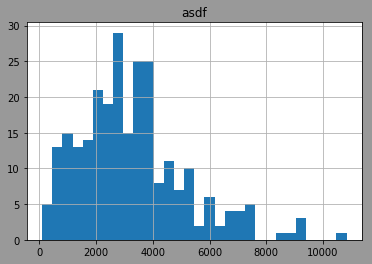

In [140]:
i = 7 # change i to desired cluster number to view 
plt.figure(facecolor = '.6')
hist_fig = dfArea[dfArea.cluster == i].area.hist(bins = 30).get_figure()
plt.title('asdf')
# dfArea.area.dropna().plot(kind='kde',xlim=(0,5*10e3), style='r--')